In [210]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import functions as fn
import datetime
import pandas_datareader.data as web
import plotly
import plotly.graph_objs as go

print(sys.executable)
print(sys.version)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/education/anaconda/envs/quant_invest/bin/python
3.7.4 (default, Aug 13 2019, 15:17:50) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [44]:
fn.get_equity_prices(assets=['AAPL', 'SPY'], start_date='2000-01-01', end_date='2003-06-30', type='Close', freq='daily')

Symbols,AAPL,SPY
date,,
2000-01-03,0.999442,145.437500
2000-01-04,0.915179,139.750000
2000-01-05,0.928571,140.000000
2000-01-06,0.848214,137.750000
2000-01-07,0.888393,145.750000
...,...,...
2003-06-24,0.335357,98.519997
2003-06-25,0.340893,97.529999
2003-06-26,0.344464,98.800003


In [43]:
fn.get_equity_returns(assets=['AAPL', 'SPY'], start_date='2019-12-31', end_date='2020-12-31', type='Adj Close', freq='monthly')

Symbols,AAPL,SPY
date,,
2019-12-31,NaN,NaN
2020-01-31,0.054010,-0.000404
2020-02-29,-0.114701,-0.079166
2020-03-31,-0.069761,-0.124871
2020-04-30,0.155374,0.126984
2020-05-31,0.085094,0.047645
2020-06-30,0.147386,0.017734
2020-07-31,0.165132,0.058892
2020-08-31,0.216569,0.069797


In [24]:
fn.get_cumulative_returns(assets=['AAPL', 'SPY'], start_date='2019-12-31', end_date='2020-12-31', type='Adj Close', freq='daily')

Symbols,AAPL,SPY
Date,,
2019-12-31,1.000000,1.000000
2020-01-02,1.022816,1.009352
2020-01-03,1.012872,1.001709
2020-01-06,1.020943,1.005530
2020-01-07,1.016142,1.002703
...,...,...
2020-12-24,1.813175,1.167871
2020-12-28,1.878024,1.177904
2020-12-29,1.853019,1.175657


In [123]:
# Fixed Coupon ELN
BUFFER = -0.15
CAP = 0.05
LEVERAGE = 1.25
COUPON = 0.05

# 0. DATA PREPROCESSING
# generate monthly returns for the Russell 2000 and MSCI EAFE
df = fn.get_equity_returns(assets=['^RUT', 'EFA'], start_date='1999-12-31', end_date='2020-12-31', type='Adj Close', freq='monthly')

# calculate a rolling 12M cumulative return for each period
df += 1
df = df.rolling(window=12).agg(lambda x: x.prod() - 1.0)

# take the worst return between the Russell and EAFE over each period 
df['market_return'] = df.min(axis=1)
df = df[df['market_return'].notnull()]

# categorize the regime
df['regime'] = 'neutral'
mask = df['market_return'] < BUFFER
df.loc[mask, 'regime'] = 'steep bear'
mask = df['market_return'] >= CAP
df.loc[mask, 'regime'] = 'bull'

# calculate etn return
df['eln_return'] = 0.05

mask = df['regime'] == 'steep bear'
df['temp'] = ((df['market_return']* LEVERAGE) - BUFFER) + COUPON
df.loc[mask, 'eln_return'] = df['temp']

total_count = df.shape[0]
overview = []

for regime in ['steep bear', 'neutral', 'bull']:
    dff = df[df['regime'] == regime]
    freq =  dff.shape[0] / total_count
    count = dff.shape[0]
    mean_market_return = dff['market_return'].mean()
    median_market_return = dff['market_return'].median()

    mean_eln_return = dff['eln_return'].mean()
    median_eln_return = dff['eln_return'].median()

    res = [regime, count, freq, mean_market_return, median_market_return, 
    mean_eln_return, median_eln_return]
    overview.append(res)

overview=pd.DataFrame(overview, columns=['regime', 'count', 'freq', 
'mean_mkt_rtn', 'median_mkt_rtn', 'mean_eln_rtn', 'median_eln_rtn'])

overview

,regime,count,freq,mean_mkt_rtn,median_mkt_rtn,mean_eln_rtn,median_eln_rtn
0,steep bear,29,0.120332,-0.274629,-0.226410,-0.143286,-0.083012
1,neutral,98,0.406639,-0.046326,-0.046510,0.050000,0.050000
2,bull,114,0.473029,0.176267,0.158896,0.050000,0.050000


In [137]:
print((df['eln_return'] > df['market_return']).mean())
print()
print(df[['market_return', 'eln_return']].mean())
print()
print(df[['market_return', 'eln_return']].median())

0.5269709543568465

Symbols
market_return    0.031495
eln_return       0.026741
dtype: float64

Symbols
market_return    0.042443
eln_return       0.050000
dtype: float64


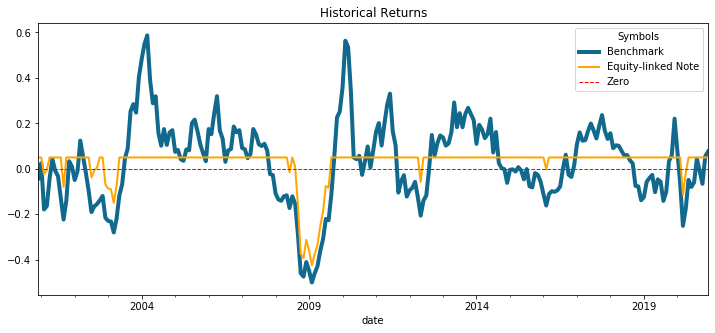

In [181]:
# plot time series of market returns vs the eln returns 
# each point represents the return of that one-year holding period
dff = df.copy()
dff['zero'] = 0

fig, axes = plt.subplots(1,1, figsize=(12,5))
dff.rename(columns={'market_return': 'Benchmark', 'eln_return': 'Equity-linked Note', 'zero': 'Zero'}, inplace=True)
dff[['Benchmark']].plot(ax=axes, linewidth=4, color='#11698e',linestyle='solid')
dff[['Equity-linked Note']].plot(ax=axes, linewidth=2, color='orange',linestyle='solid')
dff[['Zero']].plot(ax=axes, linewidth=1, color='red',linestyle='dashed')
plt.title('Historical Returns')
plt.savefig('/Users/education/Downloads/test.png')

In [286]:

trace1 = go.Scatter(x=dff.index, y=dff.Benchmark, mode='lines', name='Benchmark')
trace2 = go.Scatter(x=dff.index, y=dff['Equity-linked Note'], mode='lines', name='ELN')

dff['zero'] = 0
trace3 = go.Scatter(x=dff.index, y=dff['zero'], mode='lines', showlegend=False,  marker={'color': 'black'})

data = [trace1, trace2, trace3]
layout = {'title': {'text': '<b>Historical Returns: Benchmark and ELN</b>', 'xanchor': 'left'}, 'legend': {'orientation': 'h'}, 'margin': {'l': 10, 'r': 30, 't': 50, 'b': 20}, 'yaxis_title': 'Return', 'yaxis': {'tickformat': '.0%'}}
fig = {'data': data, 'layout': layout}
plotly.offline.iplot(fig)

In [248]:
eln_returns = dff['Equity-linked Note'].tolist()
colors = ['#00af91'] * dff.shape[0]
for i in range(len(eln_returns)):
    if eln_returns[i] < 0.05:
        colors[i] = '#eb596e'


trace1 = go.Bar(x=dff.index, y=dff.Benchmark, name='Benchmark')
trace2 = go.Bar(x=dff.index, y=dff['Equity-linked Note'], name='ELN', marker_color=colors)
data = [trace2]
layout = {'title': {'text': '<b>Simulated ELN Returns: Loss Incidents</b>', 'xanchor': 'left'}, 'margin': {'l': 10, 'r': 30, 't': 50, 'b': 20}, 'yaxis_title': 'Return', 'yaxis': {'tickformat': '.0%'}}
fig = {'data': data, 'layout': layout}
plotly.offline.iplot(fig)

In [273]:
temp = dff.copy()
temp['cap'] = CAP


trace1 = go.Scatter(x=temp.index, y=temp['cap'], mode='lines', line={'dash': 'dash'}, name='5%', fill=None, marker={'color': 'red'})

trace2 = go.Scatter(x=temp.index, y=temp.Benchmark, mode='lines', name='Benchmark', marker={'color': '#0d335d'}, fill='tonexty', fillcolor='#1a508b')

data = [trace1, trace2]

layout = {'title': {'text': '<b>Historical Market Returns Above 5%</b>', 'xanchor': 'left'}, 'legend': {'orientation': 'h'}, 'margin': {'l': 10, 'r': 30, 't': 50, 'b': 20}, 'yaxis_title': 'Return', 'yaxis': {'tickformat': '.0%'}}

fig = {'data': data, 'layout': layout}
plotly.offline.iplot(fig)

In [282]:
temp = dff.copy()
temp['cap'] = CAP
temp['zero'] = 0
temp['benchmark_high'] = temp['Benchmark']
mask = temp['benchmark_high'] < .05
temp.loc[mask, 'benchmark_high'] = 0.05

temp['benchmark_low'] = temp['Benchmark']
mask = temp['benchmark_low'] > .05
temp.loc[mask, 'benchmark_low'] = 0.05

trace1 = go.Scatter(x=temp.index, y=temp['cap'], mode='lines', name='5%', fill=None)

trace2 = go.Scatter(x=temp.index, y=temp.benchmark_high, mode='lines', marker={'color': '#ff884b'}, fill='tonexty', fillcolor='#ffc764', showlegend=False)

trace3 = go.Scatter(x=temp.index, y=temp.benchmark_low, mode='lines', marker={'color': 'blue'}, fill='tonexty', fillcolor='lightblue', showlegend=False)

trace4 = go.Scatter(x=temp.index, y=temp.zero, mode='lines', name='Zero', marker={'color': 'red'}, line={'dash': 'dash'})

data = [trace1, trace2, trace1, trace3, trace4, trace1]


layout = {'title': {'text': '<b>Historical Market Returns Above 5%</b>', 'xanchor': 'left'}, 'legend': {'orientation': 'h'}, 'margin': {'l': 10, 'r': 30, 't': 50, 'b': 20}, 'yaxis_title': 'Return', 'yaxis': {'tickformat': '.0%'}}

fig = {'data': data, 'layout': layout}
plotly.offline.iplot(fig)

In [259]:
temp[['Benchmark', 'benchmark_high', 'benchmark_low']]

Symbols,Benchmark,benchmark_high,benchmark_low
date,,,
2000-12-31,-0.042041,0.050000,-0.042041
2001-01-31,0.024404,0.050000,0.024404
2001-02-28,-0.178879,0.050000,-0.178879
2001-03-31,-0.164277,0.050000,-0.164277
2001-04-30,-0.041343,0.050000,-0.041343
...,...,...,...
2020-08-31,0.044848,0.050000,0.044848
2020-09-30,-0.010293,0.050000,-0.010293
2020-10-31,-0.066110,0.050000,-0.066110


In [198]:

labels

['',
 2001,
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 2002,
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 2003,
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 2004,
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 2005,
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 2006,
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 2007,
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 2008,
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 2009,
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 2010,
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 2011,
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 2012,
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 2013,
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 2014,
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 2015,
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 2016,
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 20

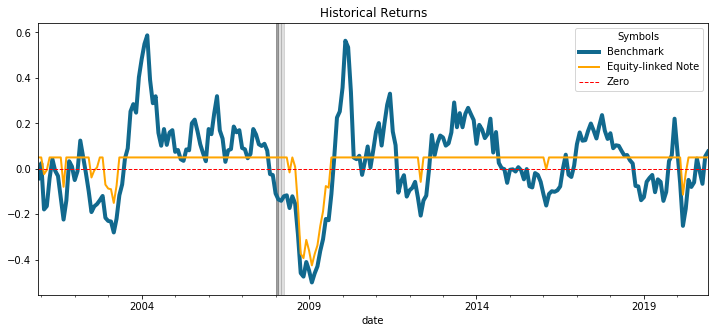

In [194]:
# plot time series of market returns vs the eln returns 
# each point represents the return of that one-year holding period
dff = df.copy()
dff['zero'] = 0

fig, axes = plt.subplots(1,1, figsize=(12,5))
dff.rename(columns={'market_return': 'Benchmark', 'eln_return': 'Equity-linked Note', 'zero': 'Zero'}, inplace=True)
dff[['Benchmark']].plot(ax=axes, linewidth=4, color='#11698e',linestyle='solid')
dff[['Equity-linked Note']].plot(ax=axes, linewidth=2, color='orange',linestyle='solid')
dff[['Zero']].plot(ax=axes, linewidth=1, color='red',linestyle='dashed')
plt.title('Historical Returns')

# add shading
y1, y2 = axes.get_ylim()
axes.axvspan(pd.to_datetime('2008-01-31'), pd.to_datetime('2008-02-28'), color='grey', alpha=0.75)
axes.axvspan(pd.to_datetime('2008-02-28'), pd.to_datetime('2008-03-31'), color='grey', alpha=0.25)
axes.axvspan(pd.to_datetime('2008-03-31'), pd.to_datetime('2008-04-30'), color='grey', alpha=0.25)



In [42]:
for drawdown in fn.big_drawdowns:
    start_date = drawdown['start']
    end_date = drawdown['end']
    name = drawdown['name']

    print(name, start_date, end_date)
    print(fn.get_cumulative_returns(['SPY', 'QQQ', 'TLT', 'BND', 'LQD', 'HYG'], start_date, end_date, type='Close', freq='daily').iloc[-1] - 1.0)
    print()

tech 2000-03-24 2002-10-29
Symbols
SPY   -0.423232
QQQ   -0.796534
TLT    0.059495
LQD    0.036796
BND         NaN
HYG         NaN
Name: 2002-10-29 00:00:00, dtype: float64

gfc 2007-10-09 2009-03-09
Symbols
SPY   -0.564737
QQQ   -0.517797
TLT    0.176504
BND    0.007966
LQD   -0.137796
HYG   -0.409182
Name: 2009-03-09 00:00:00, dtype: float64

covid 2020-02-19 2020-03-23
Symbols
SPY   -0.341047
QQQ   -0.280699
TLT    0.140658
BND   -0.016280
LQD   -0.125296
HYG   -0.222411
Name: 2020-03-23 00:00:00, dtype: float64



In [ ]:
def get_drawdowns():
    '''
    identify time periods when the specified asset experienced a drawdown of at least X%
    '''